### 1. Instalación e importanción de librerías.

In [1]:
# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect

In [2]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

import re, string, unicodedata
import contractions
import inflect
from sklearn import tree
from sklearn import svm
from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 

In [3]:
# librería Natural Language Toolkit, usada para trabajar con textos 
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
# ¿Cuales son esas palabras vacías?
nltk.download('stopwords')
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
# ¿Qué es el lema de una palabra? ¿Qué tan dificil puede ser obtenerlo, piensa en el caso en que tuvieras que escribir la función que realiza esta tarea?
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

# Proyecto 1 - Elegibilidad de un paciente
### Nombre: Dianis Caro
Determinar la elegibilidad de un paciente para ensayos clínicos de cáncer a partir de 
texto descriptivo.

## Entendimiento de los datos

In [5]:
#Importar los datos
df_original = pd.read_csv('clinical_trials_on_cancer_data_clasificacion.csv', sep=',', encoding = 'utf-8')
first_row = df_original[0:1].copy()
df_original

,label,study_and_condition
0,__label__0,study interventions are Saracatinib . recurren...
1,__label__1,study interventions are Stem cell transplantat...
2,__label__0,study interventions are Lenograstim . recurren...
3,__label__0,study interventions are Doxorubicin . stage ii...
4,__label__1,study interventions are Poly I-C . prostate ca...
...,...,...
11995,__label__0,study interventions are Prednisolone hemisucci...
11996,__label__0,study interventions are Bevacizumab . recurren...
11997,__label__1,"study interventions are Antibodies, Monoclonal..."
11998,__label__0,study interventions are Vorinostat . colorecta...


Notamos que existe una columna con dos datos que se deben tratar diferente por lo tanto, se decide separarlos.

In [6]:
#Separar la columna study_and_condition
additional_df = df_original["study_and_condition"].str.split('.', 1, expand=True)
additional_df.columns = ['study', 'condition']
df_original = pd.concat([df_original, additional_df], axis=1)
df_original.drop('study_and_condition', axis=1, inplace=True)
df_original

,label,study,condition
0,__label__0,study interventions are Saracatinib,recurrent verrucous carcinoma of the larynx d...
1,__label__1,study interventions are Stem cell transplantat...,hodgkin lymphoma diagnosis and history of con...
2,__label__0,study interventions are Lenograstim,recurrent adult diffuse mixed cell lymphoma d...
3,__label__0,study interventions are Doxorubicin,stage iii diffuse large cell lymphoma diagnos...
4,__label__1,study interventions are Poly I-C,prostate cancer diagnosis and unresolved irae...
...,...,...,...
11995,__label__0,study interventions are Prednisolone hemisucci...,recurrent childhood large cell lymphoma diagn...
11996,__label__0,study interventions are Bevacizumab,recurrent rectal cancer diagnosis and absolut...
11997,__label__1,"study interventions are Antibodies, Monoclonal",recurrent lymphoblastic lymphoma diagnosis an...
11998,__label__0,study interventions are Vorinostat,colorectal cancer diagnosis and patients must...


In [7]:
df_original.shape

(12000, 3)

Se tienen 12000 filas y 3 variables. Se observan el estado de los datos:

In [8]:
#Valores nulos/vacíos
number_rows = len(df_original)
values_graf = []
for i in df_original.keys():
    nan = df_original[i].isna().sum()
    percentage = round((nan*100)/number_rows,2)
    if(percentage>0):
        values_graf.append([i,percentage])
    print('La columna {} tiene {} de valores vacíos'.format(i,percentage))

La columna label tiene 0.0 de valores vacíos
La columna study tiene 0.0 de valores vacíos
La columna condition tiene 0.0 de valores vacíos


No se presentan anomalías.

[Text(0, 0, '6000'), Text(0, 0, '6000')]

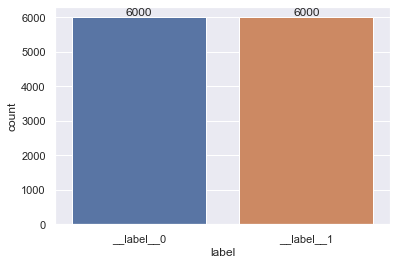

In [9]:
ax = sns.countplot(x='label', data=df_original)
ax.bar_label(ax.containers[0])

Se evidencia un balance respecto a la variable objetivo por lo que no se proponen estrategias de balanceo en el preprocesamiento a continuación.

## Preprocesamiento de los datos

### Columna objetivo (Label)

In [10]:
df_original['label'].unique()

array(['__label__0', '__label__1'], dtype=object)

Revisamos el estado de los valores de la variable objetivo. No se presentan anomalías, por lo tanto procedemos a simplificar la notación de la columna. Notación: '_label_0' será 0 y '_label_1' será 1.

In [11]:
#Limpiar la columna label
def limpiar_label(value):
    if value=='__label__0':
        return 0
    else:
        return 1

df_original['label'] = df_original['label'].map(limpiar_label)

### Columna study

In [12]:
df_original['study'].value_counts()

study interventions are Antibodies, Monoclonal                439
study interventions are Albumin-Bound Paclitaxel              269
study interventions are Paclitaxel                            269
study interventions are Antibodies                            260
study interventions are Bevacizumab                           239
                                                             ... 
study interventions are rF-PSA                                  1
study interventions are iodinated contrast dye                  1
study interventions are JCAR017 2-dose schedule                 1
study interventions are E6201                                   1
study interventions are PV-10 (rose bengal disodium, 10%)       1
Name: study, Length: 1660, dtype: int64

In [13]:
#Limpiar la columna study
def limpiar_study(value):
    return value.replace('study interventions are ', '')

df_original['study'] = df_original['study'].map(limpiar_study)

Verificación de los cambios realizados:

In [14]:
df_original

,label,study,condition
0,0,Saracatinib,recurrent verrucous carcinoma of the larynx d...
1,1,Stem cell transplantation,hodgkin lymphoma diagnosis and history of con...
2,0,Lenograstim,recurrent adult diffuse mixed cell lymphoma d...
3,0,Doxorubicin,stage iii diffuse large cell lymphoma diagnos...
4,1,Poly I-C,prostate cancer diagnosis and unresolved irae...
...,...,...,...
11995,0,Prednisolone hemisuccinate,recurrent childhood large cell lymphoma diagn...
11996,0,Bevacizumab,recurrent rectal cancer diagnosis and absolut...
11997,1,"Antibodies, Monoclonal",recurrent lymphoblastic lymphoma diagnosis an...
11998,0,Vorinostat,colorectal cancer diagnosis and patients must...


### Limpieza de datos
Para dejar el archivo en texto plano. También para eliminar caracteres especiales y pasar todo a minúscula.

In [15]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words =[]
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    stopwords = nltk.corpus.stopwords.words('english')
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### Tokenización
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos. 

In [16]:
df_original['condition'] = df_original['condition'].apply(contractions.fix) #Aplica la corrección de las contracciones
df_original['words'] = df_original['condition'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
df_original

,label,study,condition,words
0,0,Saracatinib,recurrent verrucous carcinoma of the larynx d...,"[recurrent, verrucous, carcinoma, larynx, diag..."
1,1,Stem cell transplantation,hodgkin lymphoma diagnosis and history of con...,"[hodgkin, lymphoma, diagnosis, history, congen..."
2,0,Lenograstim,recurrent adult diffuse mixed cell lymphoma d...,"[recurrent, adult, diffuse, mixed, cell, lymph..."
3,0,Doxorubicin,stage iii diffuse large cell lymphoma diagnos...,"[stage, iii, diffuse, large, cell, lymphoma, d..."
4,1,Poly I-C,prostate cancer diagnosis and unresolved irae...,"[prostate, cancer, diagnosis, unresolved, irae..."
...,...,...,...,...
11995,0,Prednisolone hemisuccinate,recurrent childhood large cell lymphoma diagn...,"[recurrent, childhood, large, cell, lymphoma, ..."
11996,0,Bevacizumab,recurrent rectal cancer diagnosis and absolut...,"[recurrent, rectal, cancer, diagnosis, absolut..."
11997,1,"Antibodies, Monoclonal",recurrent lymphoblastic lymphoma diagnosis an...,"[recurrent, lymphoblastic, lymphoma, diagnosis..."
11998,0,Vorinostat,colorectal cancer diagnosis and patients must...,"[colorectal, cancer, diagnosis, patients, must..."


### Normalización
En la normalización de los datos se realiza la eliminación de prefijos y sufijos, además de realizar una lemmatización.

In [17]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

df_original['words'] = df_original['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
df_original.head()

,label,study,condition,words
0,0,Saracatinib,recurrent verrucous carcinoma of the larynx d...,"[recur, verruc, carcinom, larynx, diagnos, pat..."
1,1,Stem cell transplantation,hodgkin lymphoma diagnosis and history of con...,"[hodgkin, lymphom, diagnos, hist, congenit, he..."
2,0,Lenograstim,recurrent adult diffuse mixed cell lymphoma d...,"[recur, adult, diffus, mix, cel, lymphom, diag..."
3,0,Doxorubicin,stage iii diffuse large cell lymphoma diagnos...,"[stag, ii, diffus, larg, cel, lymphom, diagnos..."
4,1,Poly I-C,prostate cancer diagnosis and unresolved irae...,"[prost, cant, diagnos, unresolv, ira, follow, ..."


 ### Selección de campos
 Primero, se separa la variable predictora y los textos que se van a utilizar.

In [18]:
df_original['words'] = df_original['words'].apply(lambda x: ' '.join(map(str, x)))
df_original

,label,study,condition,words
0,0,Saracatinib,recurrent verrucous carcinoma of the larynx d...,recur verruc carcinom larynx diagnos paty must...
1,1,Stem cell transplantation,hodgkin lymphoma diagnosis and history of con...,hodgkin lymphom diagnos hist congenit hematolo...
2,0,Lenograstim,recurrent adult diffuse mixed cell lymphoma d...,recur adult diffus mix cel lymphom diagnos cre...
3,0,Doxorubicin,stage iii diffuse large cell lymphoma diagnos...,stag ii diffus larg cel lymphom diagnos stag i...
4,1,Poly I-C,prostate cancer diagnosis and unresolved irae...,prost cant diagnos unresolv ira follow pri bio...
...,...,...,...,...
11995,0,Prednisolone hemisuccinate,recurrent childhood large cell lymphoma diagn...,recur child larg cel lymphom diagnos known hyp...
11996,0,Bevacizumab,recurrent rectal cancer diagnosis and absolut...,recur rect cant diagnos absolv neutrophil coun...
11997,1,"Antibodies, Monoclonal",recurrent lymphoblastic lymphoma diagnosis an...,recur lymphoblast lymphom diagnos intrathec in...
11998,0,Vorinostat,colorectal cancer diagnosis and patients must...,colorect cant diagnos paty must receiv least o...


In [19]:
X_data, y_data = df_original['words'],df_original['label']
y_data = (y_data == 0).astype(int)
y_data

0        1
1        0
2        1
3        1
4        0
        ..
11995    1
11996    1
11997    0
11998    1
11999    1
Name: label, Length: 12000, dtype: int32

Primero, se transforma el texto con una transformación binaria 1 a 1.

In [20]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data)
print(X_dummy.shape)
X_dummy.toarray()[0]

(12000, 9103)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [21]:
count = CountVectorizer()
X_count = count.fit_transform(X_data)
print(X_count.shape)
X_count.toarray()[0]

(12000, 9103)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Creación y Aplicación del modelo - Árboles de decisión
Una vez se tiene la representación vectorial de cada uno de los textos se debe crear un modelo que permita clasificarlos en las categorias correspondientes. Para esto se pueden usar cualquiera de las representaciones anteriormente creadas.

In [22]:
# Dividir los datos en entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(X_dummy, y_data, test_size = 0.2, random_state = 0)

En el caso de los árboles de decisión los hiperparámetros principales que hay que ajustar están relacionados con aquellos que controlan la complejidad, pero también el criterio o medida de pureza puede afectar su rendimiento.Se usará le técnica de K-Fold Cross Validation para encontrar los hiperparámetros ideales.

In [23]:
# Se fija el número de particiones. Se usará K = 10.
particiones = KFold(n_splits = 10, shuffle = True, random_state = 0)

# Se establece el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [4, 6, 8, 10, 20], 'min_samples_split': [2, 3, 4, 5]}

# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol_inicial = DecisionTreeClassifier(random_state = 0)

# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol_inicial, param_grid, cv = particiones)

# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 3}

Se puede ver que los hiperparámetros óptimos son un criterio de gini, una profundidad máxima de 20 y una cantidad de 3 como criterio mínimo de división de nodos internos.

In [24]:
# Obtener el mejor modelo.
arbol = mejor_modelo.best_estimator_

## Evaluación
Se procede a evaluar el desempeño del modelo con los datos de entrenamiento y con los datos de prueba.

In [25]:
# Probemos ahora este modelo sobre test.
y_pred_train = arbol.predict(X_train)
y_pred_test = arbol.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.80
Exactitud sobre test: 0.73


Datos de entranamiento
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      4828
           1       0.74      0.92      0.82      4772

    accuracy                           0.80      9600
   macro avg       0.82      0.80      0.80      9600
weighted avg       0.82      0.80      0.80      9600



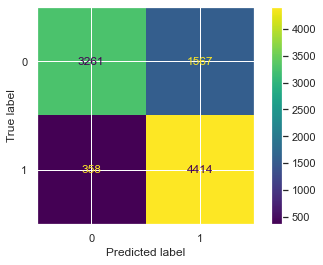

In [26]:
# Se imprime el informe de rendimiento - entrenamiento
print("Datos de entranamiento")
print(classification_report(Y_train, y_pred_train))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(arbol, X_train, Y_train)  
plt.show()

Datos de prueba
              precision    recall  f1-score   support

           0       0.79      0.61      0.69      1172
           1       0.70      0.84      0.76      1228

    accuracy                           0.73      2400
   macro avg       0.74      0.73      0.73      2400
weighted avg       0.74      0.73      0.73      2400



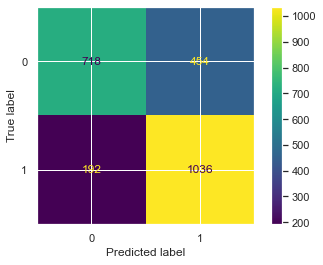

In [27]:
# Se imprime el informe de rendimiento - prueba
print("Datos de prueba")
print(classification_report(Y_test, y_pred_test))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(arbol, X_test, Y_test)  
plt.show()  

## Support Vector Classification

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dummy, y_data, test_size = 0.2, random_state = 0)

Para el algoritmo de Support Vector Classification hay 2 hiperparámetros que afectan en gran medida la clasificación: kernel y C. El valor de kernel determina cómo se forma el límite o superficie de decisión, por ejemplo, si tiene un comportamiento lineal o no lineal. Para este hiperparámetro se prueba con kernel lineal (linear), polinómico (poly) y de función radial (rbf). Por otro lado, el hiperparámetro de C determina la margen o nivel de tolerancia para las superficies de decisión, y entre más grande es el valor de C más pequeño será el margen y tendrá menos registros que definen la superficie, y viceversa.
Para cada tipo de kernel se probaron valores de C entre 0.2 y 2 y se presentan a continuación los mejores resultados para cada uno.

### Lineal
Para el kernel lineal se identificó que independiente del valor de C, la proporción de TP siempre es mayor que la de TN, aunque se mantienen cercanos, y se prefirió el valor de C donde se maximizara la cantidad de correctamente clasificados que se presentó en C=0.2.

Lineal: Datos de prueba
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1172
           1       0.80      0.79      0.80      1228

    accuracy                           0.80      2400
   macro avg       0.80      0.80      0.80      2400
weighted avg       0.80      0.80      0.80      2400



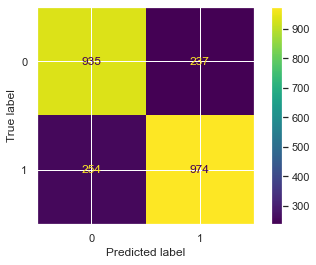

In [29]:
clf = svm.SVC(kernel = "linear", C=0.2)
clf_trained = clf.fit(X_train,Y_train)
clf_trained.score(X_train,Y_train)
y_pred_test = clf_trained.predict(X_test)
print("Lineal: Datos de prueba")
print(classification_report(Y_test, y_pred_test))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(clf_trained, X_test, Y_test)  
plt.show()

### Polinómico
Para este kernel se identificó que entre menor fuera el valor de C, mayor era la proporción de TP pero menor la de TN. Sin embargo, se buscó un punto donde se maximizara la cantidad de correctamente clasificados donde hubiera un balance entre TP y TN, que se presentó en C=2.

Polinomial: Datos de prueba
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1172
           1       0.80      0.84      0.82      1228

    accuracy                           0.81      2400
   macro avg       0.81      0.81      0.81      2400
weighted avg       0.81      0.81      0.81      2400



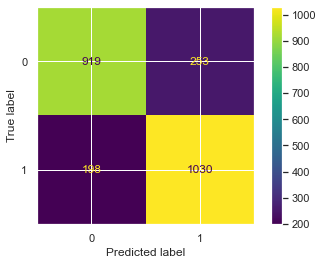

In [30]:
clf = svm.SVC(kernel = "poly", C=2)
clf_trained = clf.fit(X_train,Y_train)
clf_trained.score(X_train,Y_train)
y_pred_test = clf_trained.predict(X_test)
print("Polinomial: Datos de prueba")
print(classification_report(Y_test, y_pred_test))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(clf_trained, X_test, Y_test)  
plt.show()

### Función radial (Modelo escogido para el algoritmo de SVM)
En este kernel se identificó un buen balance entre la clasificación para TP y TN en la mayoría de valores probados para C. Al igual que en los demás kernel, se buscó el punto donde se maximizaran los correctamente clasificados, que se dio en C=1.6, dado que esto significa que es el punto donde menos personas son clasificadas incorrectamente. Por tanto, aquellos que realmente necesitan el ensayo clínico se identifican con claridad y una baja proporción de los que no lo necesitan, o que sí lo necesitan y son clasificados erróneamente, se introducen al ensayo.

In [31]:
clf = svm.SVC(kernel = "rbf", C=1.6)
clf_trained = clf.fit(X_train,Y_train)
clf_trained.score(X_train,Y_train)

0.9553125

Se evidencia que el modelo tiene una buena exactitud tanto en los datos de entrenamiento como en los de prueba, lo que es un indicador de la calidad del modelo. Así mismo, se obtiene el comportamiento esperado de que la exactitud sea mayor sobre el entrenamiento, pero no disminuye de manera anormal para los datos de prueba.

In [32]:
# Probemos ahora este modelo sobre test.
y_pred_train = clf_trained.predict(X_train)
y_pred_test = clf_trained.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.96
Exactitud sobre test: 0.82


De acuerdo con la evaluación del modelo para los datos de entrenamiento, no se identifica un comportamiento anormal en la clasificación o problemas como underfitting y overfitting.

Datos de entranamiento
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      4828
           1       0.95      0.96      0.96      4772

    accuracy                           0.96      9600
   macro avg       0.96      0.96      0.96      9600
weighted avg       0.96      0.96      0.96      9600



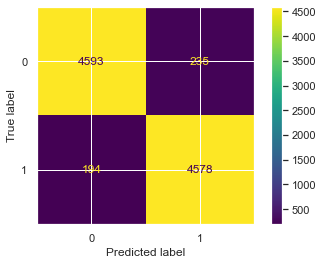

In [33]:
# Se imprime el informe de rendimiento - entrenamiento
print("Datos de entranamiento")
print(classification_report(Y_train, y_pred_train))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(clf_trained, X_train, Y_train)  
plt.show()

Se evidencia sobre los datos de prueba que se realiza una clasificación balanceada sobre la variable objetivo, que es ideal para el negocio dadas sus implicaciones sobre el bienestar de los pacientes.

Datos de prueba
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1172
           1       0.84      0.81      0.82      1228

    accuracy                           0.82      2400
   macro avg       0.82      0.82      0.82      2400
weighted avg       0.82      0.82      0.82      2400



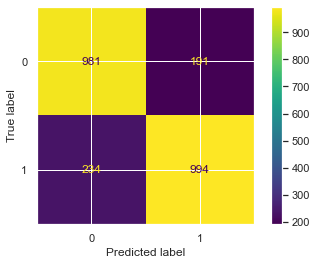

In [34]:
# Se imprime el informe de rendimiento - prueba
print("Datos de prueba")
print(classification_report(Y_test, y_pred_test))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(clf_trained, X_test, Y_test)  
plt.show()  

## KNN

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dummy, y_data, test_size = 0.2, random_state = 0)

Para el algoritmo KNN son importantes tres hiperparámetros: n_neighbors que es el número de vecinos que se analizarán; weights que es la función de peso, que define el peso de los vecinos en la formación de los grupos, está "uniform" que les asigna pesos uniformes y "distance" que les asigna pesos basados en la distancia (inversos a la distancia); y metric que define la métrica de la distancia.

Modelo con parametros default

Datos de prueba


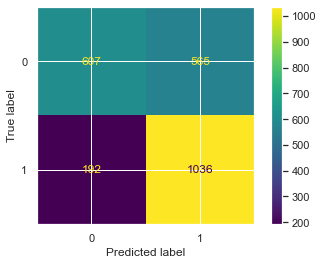

              precision    recall  f1-score   support

           0       0.76      0.52      0.62      1172
           1       0.65      0.84      0.73      1228

    accuracy                           0.68      2400
   macro avg       0.70      0.68      0.67      2400
weighted avg       0.70      0.68      0.68      2400



In [36]:
#Se plantea el modelo de KNN
modelo = KNeighborsClassifier()
#Se entrena el modelo
knn = modelo.fit(X_train,Y_train)
#Se determinan las predicciones en los datos de prueba
pred = modelo.predict(X_test)
#Se visualiza la matriz de confusión del modelo sobre los datos de prueba
print("Datos de prueba")
plot_confusion_matrix(knn, X_test, Y_test)  
plt.show()  
print(classification_report(Y_test, pred))

In [37]:
#Realizar predicciones en datos de prueba y de entrenamiento 
test = knn.predict(X_test) 
train = knn.predict(X_train) 
#Imprimir exactitud de prueba y entrenamiento
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, test))

Exactitud sobre entrenamiento: 0.78
Exactitud sobre test: 0.68


Datos de entrenamiento


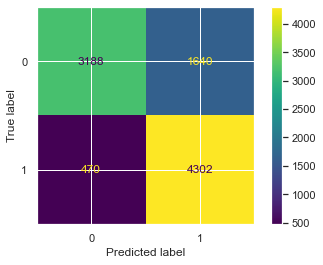

              precision    recall  f1-score   support

           0       0.87      0.66      0.75      4828
           1       0.72      0.90      0.80      4772

    accuracy                           0.78      9600
   macro avg       0.80      0.78      0.78      9600
weighted avg       0.80      0.78      0.78      9600



In [38]:
#Resultados datos prueba
print("Datos de entrenamiento")
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(knn, X_train, Y_train) 
plt.show()  
print(classification_report(Y_train, train))

In [39]:
print('Neighbors: {}, Weight: {}, Metric: {}'.format(knn.get_params()['n_neighbors'],knn.get_params()['weights'],knn.get_params()['metric'],))

Neighbors: 5, Weight: uniform, Metric: minkowski


Busqueda del mejor modelo

Para hallar el mejor modelo se utilizará la técnica de K-Fold Cross Validation, que evalua el modelo partiendo los datos en grupos diferentes para poder usar cada grupo como el de test y los demás como entrenamiento y así correr el modelo varias veces y validar la mejor opción. Se utilizará GridSearch para hallar la mejor combinación.

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dummy, y_data, test_size = 0.2, random_state = 0)
#Se realizan 10 particiones de grupos para el k-fold
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
#Se crean opciones para hacer las diferentes combinaciones
param_grid = {'n_neighbors':[5,10,15,20,25], 'weights':['uniform','distance'], 'metric':['euclidean', 'manhattan', 'minkowski']}
gs = GridSearchCV(modelo, param_grid, verbose = 1, cv = particiones, n_jobs=-1)
results = gs.fit(X_train, Y_train)
#Se ven los resultados del grid search
gs.best_params_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [41]:
#Realizar predicciones en datos de prueba y de entrenamiento 
predi_test = results.predict(X_test) 
predi_train = results.predict(X_train) 
#Imprimir exactitud de prueba y entrenamiento
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, predi_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, predi_test))

Exactitud sobre entrenamiento: 1.00
Exactitud sobre test: 0.69


Datos de prueba


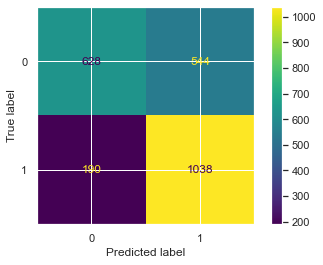

              precision    recall  f1-score   support

           0       0.77      0.54      0.63      1172
           1       0.66      0.85      0.74      1228

    accuracy                           0.69      2400
   macro avg       0.71      0.69      0.68      2400
weighted avg       0.71      0.69      0.69      2400



In [42]:
#Resultados datos prueba
print("Datos de prueba")
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(gs, X_test, Y_test)  
plt.show()  
print(classification_report(Y_test, predi_test)) 

Datos de entrenamiento


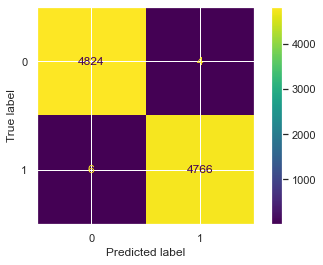

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4828
           1       1.00      1.00      1.00      4772

    accuracy                           1.00      9600
   macro avg       1.00      1.00      1.00      9600
weighted avg       1.00      1.00      1.00      9600



In [43]:
#Resultados datos entrenamiento
print("Datos de entrenamiento")
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(gs, X_train, Y_train)  
plt.show()  
print(classification_report(Y_train, predi_train)) 

Prueba con un numero de vecinos mayor

Se puede observar que el modelo genera una exactitud de 100% en los datos de entrenamiento por lo que se sabe que genera overfitting. Se probará con un número de vecinos mayor

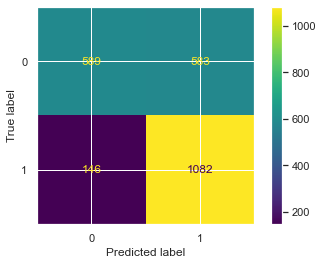

              precision    recall  f1-score   support

           0       0.80      0.50      0.62      1172
           1       0.65      0.88      0.75      1228

    accuracy                           0.70      2400
   macro avg       0.73      0.69      0.68      2400
weighted avg       0.72      0.70      0.68      2400



In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dummy, y_data, test_size = 0.2, random_state = 0)
#Se plantea el modelo de KNN
modelo_prueba = KNeighborsClassifier(metric ='manhattan', n_neighbors= 10, weights ='distance')
#Se entrena el modelo
knn_prueba = modelo_prueba.fit(X_train,Y_train)
#Se determinan las predicciones en los datos de prueba
pred_prueba = modelo_prueba.predict(X_test)
#Se visualiza la matriz de confusión del modelo sobre los datos de prueba
plot_confusion_matrix(knn_prueba, X_test, Y_test)  
plt.show()  
print(classification_report(Y_test, pred_prueba))

In [45]:
#Realizar predicciones en datos de prueba y de entrenamiento 
predi_test_prueba = knn_prueba.predict(X_test) 
predi_train_prueba = knn_prueba.predict(X_train) 
#Imprimir exactitud de prueba y entrenamiento
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, predi_train_prueba))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, predi_test_prueba))

Exactitud sobre entrenamiento: 1.00
Exactitud sobre test: 0.70


Este modelo también genera overfitting por lo que se usará el modelo con los hiperparámetros en el default

## Exportar el modelo escogido
Se usa la librería joblib para exportar el modelo de SVC

In [46]:
dump(clf_trained,'svcmodel.joblib')

['svcmodel.joblib']

## Elegibilidad de un nuevo registro
Para determinar la elegibilidad de un registro nuevo se deben aplicar las transformaciones que se aplicaron a los datos de entrenamiento, que se unificaron en el siguiente pipeline:

In [47]:
class LimpiezaTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def limpiar_label(self,value):
        if value=='__label__0':
            return 0
        else:
            return 1
    
    def limpiar_study(self,value):
        return value.replace('study interventions are ', '')
    
    def remove_non_ascii(self,words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words

    def to_lowercase(self,words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words =[]
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words

    def remove_punctuation(self,words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words

    def replace_numbers(self,words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words

    def remove_stopwords(self,words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        stopwords = nltk.corpus.stopwords.words('english')
        for word in words:
            if word not in stopwords:
                new_words.append(word)
        return new_words

    def preprocessing(self,words):
        words = self.to_lowercase(words)
        words = self.replace_numbers(words)
        words = self.remove_punctuation(words)
        words = self.remove_non_ascii(words)
        words = self.remove_stopwords(words)
        return words
    def transform(self, X, y=None):
        X_ = X.copy()
        X_add = X_["study_and_condition"].str.split('.', 1, expand=True)
        X_add.columns = ['study', 'condition']
        X_ = pd.concat([X_, X_add], axis=1)
        X_.drop('study_and_condition', axis=1, inplace=True)
        X_['label'] = X_['label'].map(self.limpiar_label)
        X_['study'] = X_['study'].map(self.limpiar_study)
        X_['condition'] = X_['condition'].apply(contractions.fix) #Aplica la corrección de las contracciones
        X_['words'] = X_['condition'].apply(word_tokenize).apply(self.preprocessing) #Aplica la eliminación del ruido
        return X_

class NormalizacionTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def stem_words(self,words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems

    def lemmatize_verbs(self,words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas

    def stem_and_lemmatize(self,words):
        stems = self.stem_words(words)
        lemmas = self.lemmatize_verbs(words)
        return stems + lemmas

    def transform(self, X, y=None):
        X_ = X.copy()
        X_['words'] = X_['words'].apply(self.stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
        X_['words'] = X_['words'].apply(lambda x: ' '.join(map(str, x)))
        return X_

Posterior a tener el pipeline de preprocesamiento se aplica la vectorización binaria al registro y se usa el modelo entrenado para hacer la predicción.

In [48]:
pipe1 = Pipeline(steps=[('limpieza',LimpiezaTransformer()),
                       ('normalizar',NormalizacionTransformer())])
def eligibility(register):
    registrotrans = pipe1.transform(register)
    registrotrans = dummy.transform(registrotrans['words'])
    return 'Eligible' if clf_trained.predict(registrotrans)[0] == 1 else 'Not eligible'

In [49]:
eligibility(first_row)

'Eligible'